In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
import nltk

# Tokenizing
nltk.download('punkt')
# Stopwords removal
nltk.download('stopwords')
# Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

print('Completed')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Completed


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

# Load Data

Text Data (feedback & summary)

In [ ]:
file_path = "/content/drive/MyDrive/CAPSTONE/Dataset/text-sum-preprocessing/summary_dataset.csv"
df = pd.read_csv(file_path)
df

,summary,text
0,Penyetan jawa timur,"Leko merupakan resto penyetan khas jawa timur. Kami memesan empal penyet Dan nasi goreng bakso.Empal penyetnya empuk, bumbunya cukup terasa, sambalnya enak dan mantap sekali, hanya sayang dikasih ..."
1,Ayam Bakarrrr,Bukber sama temen2 disini aku pesen yg Ayam Bakar Penyet. Bumbu ayam nya berasa bgt manis trus juga daging nya gak keras. Walaupun keliatan overcook tapi ngga ada rasa pait. Buat sambelnya aku suk...
2,Nasi Goreng Teri Medan,"Menu yang saya pesan Nasi Goreng Teri Medan @Rp40.000.Rasanya sendiri lumayan enak, ga terlalu asin, gurihnya pas. Agak terlalu berminyak dikit tapi masih ok.Servicenya sendiri ramah, tempatnya ju..."
3,Juicy,Kedapatan mengunjungi outlet warung leko yang menyediakan aneka hidangan penyetan khas jawa timur .Memesan menu andalan mereka yakni iga penyet serta sate jamur dengan tingkat level sedang untuk p...
4,Kenyang,Makanan indonesia dengan segala macem sambel tinggal pilih aja mau yg mana.Liat menunya lumayan banyak juga yg daging sapi. Tapi akhirnya ga ada order sapi wkwk.Menu yg diorder :- Nasi Goreng Teri...
...,...,...
1143,Kwetiau Bun nya lumayan,"Iseng - iseng coba makan di Kwetiaw Sapi Mangga Besar yang di greenville, karena banyak yang bilang enak jadi penasaran buat cobain. \nDisini yang recommended itu kata mbak nya Kwetiau Siram Telur..."
1144,Kwetiau Siram Telornya Recommended!,Udah lama denger nama Kwetiau sapi satu ini tapi baru kali ini sempet buat nyobain. Sampe disini minta rekomendasi ke pelayannya dan dia merekomendasikan Kwetiau Siram Telur. Jadilah saya memesan ...
1145,Kwetiaw Sapi Legenda,Kwetiaw Sapi Mangga Besar 78 ini boleh dibilang salah 1 legenda Kwetiaw di daerah Mangga Besar juga....beda dengan 2 pendekar Kwetiaw yang lain : Kwetiaw Akang & Kwetiaw Sapi Aciap yang mulai berd...
1146,kwetiaunya enak banget !!,"Kwetiau sapi yang satu ini emang terkenal banget nih guys, so saya jadi penasaran ingin mencobanya. Disini ada banyak pilihan buat kwetiaunya, ada yang goreng, bun, siram, kuah. Hmm sempet bingung..."


ID Stopword

In [ ]:
id_stopword_dict = pd.read_csv('/content/drive/MyDrive/CAPSTONE/Dataset/text-sum-preprocessing/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

In [ ]:
print("Shape: ", id_stopword_dict.shape)
id_stopword_dict

Shape:  (758, 1)


,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak
...,...
753,wong
754,yaitu
755,yakin
756,yakni


# Preprocessing

Drop duplicates and NA values

In [ ]:
df.drop_duplicates(subset=['text'],inplace=True)
df.dropna(axis=0,inplace=True)
df

,summary,text
0,Penyetan jawa timur,"Leko merupakan resto penyetan khas jawa timur. Kami memesan empal penyet Dan nasi goreng bakso.Empal penyetnya empuk, bumbunya cukup terasa, sambalnya enak dan mantap sekali, hanya sayang dikasih ..."
1,Ayam Bakarrrr,Bukber sama temen2 disini aku pesen yg Ayam Bakar Penyet. Bumbu ayam nya berasa bgt manis trus juga daging nya gak keras. Walaupun keliatan overcook tapi ngga ada rasa pait. Buat sambelnya aku suk...
2,Nasi Goreng Teri Medan,"Menu yang saya pesan Nasi Goreng Teri Medan @Rp40.000.Rasanya sendiri lumayan enak, ga terlalu asin, gurihnya pas. Agak terlalu berminyak dikit tapi masih ok.Servicenya sendiri ramah, tempatnya ju..."
3,Juicy,Kedapatan mengunjungi outlet warung leko yang menyediakan aneka hidangan penyetan khas jawa timur .Memesan menu andalan mereka yakni iga penyet serta sate jamur dengan tingkat level sedang untuk p...
4,Kenyang,Makanan indonesia dengan segala macem sambel tinggal pilih aja mau yg mana.Liat menunya lumayan banyak juga yg daging sapi. Tapi akhirnya ga ada order sapi wkwk.Menu yg diorder :- Nasi Goreng Teri...
...,...,...
1143,Kwetiau Bun nya lumayan,"Iseng - iseng coba makan di Kwetiaw Sapi Mangga Besar yang di greenville, karena banyak yang bilang enak jadi penasaran buat cobain. \nDisini yang recommended itu kata mbak nya Kwetiau Siram Telur..."
1144,Kwetiau Siram Telornya Recommended!,Udah lama denger nama Kwetiau sapi satu ini tapi baru kali ini sempet buat nyobain. Sampe disini minta rekomendasi ke pelayannya dan dia merekomendasikan Kwetiau Siram Telur. Jadilah saya memesan ...
1145,Kwetiaw Sapi Legenda,Kwetiaw Sapi Mangga Besar 78 ini boleh dibilang salah 1 legenda Kwetiaw di daerah Mangga Besar juga....beda dengan 2 pendekar Kwetiaw yang lain : Kwetiaw Akang & Kwetiaw Sapi Aciap yang mulai berd...
1146,kwetiaunya enak banget !!,"Kwetiau sapi yang satu ini emang terkenal banget nih guys, so saya jadi penasaran ingin mencobanya. Disini ada banyak pilihan buat kwetiaunya, ada yang goreng, bun, siram, kuah. Hmm sempet bingung..."


Function for pre-processing

In [ ]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('\r',' ',text) # Remove every '\r'
    text = re.sub('(?i)rt',' ',text) # Remove every retweet symbol
    text = re.sub('@[^\s]+[ \t]','',text) # Remove every username
    text = re.sub('(?i)user','',text) # Remove every username
    text = re.sub('(?i)url',' ',text) # Remove every url
    text = re.sub(r'\\x..',' ',text) # Remove every emoji
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) #Remove characters repeating more than twice

    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    #text = re.sub(r'\d+', ' ', text)
    return text

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = remove_unnecessary_char(text) # 1
    text = lowercase(text) # 2
    text = remove_nonaplhanumeric(text) # 3
    text = stemming(text) # 4
    text = remove_stopword(text) # 5
    return text

In [ ]:
df = df.applymap(preprocess)
df

,summary,text
0,penyet jawa timur,leko rupa resto penyet khas jawa timur mes empal penyet nasi goreng bakso empal penyet empuk bumbu asa sambal enak mantap sayang kasih lalap dikit nasi goreng bakso so so aja nasi goreng minyak ma...
1,ayam bakarr,bukber temen2 sen yg ayam bakar penyet bumbu ayam nya asa bgt manis trus daging nya gak keras liat overcook ngga pait sambelnya suka gak pedes yg cetar poko bikin makan lahap deh suasana nya nyama...
2,nasi goreng teri medan,menu pesan nasi goreng teri medan lumayan enak ga asin gurih pas minyak dikit ok servicenya ramah nyaman
3,juicy,unjung outlet warung leko sedia aneka hidang penyet khas jawa timur mes menu andal iga penyet a sate jamur tingkat level pedas iga sapi empuk gurih sambal cobek ga pedas sesuai request sate jamur ...
4,kenyang,makan indonesia macem sambel tinggal pilih aja yg liat menu lumayan yg daging sapi ga order sapi wkwk menu yg order nasi goreng teri medan 38k puas kerupuk keliling piring porsi nampol dominan man...
...,...,...
1143,kwetiau bun nya lumayan,iseng iseng coba makan kwetiaw sapi mangga greenville bilang enak penasaran cobain recommended mbak nya kwetiau siram telur nya ga ken makan kuah sen kwetiau bun sapi nya aja nya lumayan enak kalo...
1144,kwetiau siram telor recommended,udah denger nama kwetiau sapi kali sempet nyobain sampe rekomendasi layan rekomendasi kwetiau siram telur mes kwetiau siram telur porsi nya lumayan kenyang kwetiau nya enak ga heran kwetiau sapi t...
1145,kwetiaw sapi legenda,kwetiaw sapi mangga 78 bilang salah 1 legenda kwetiaw daerah mangga beda 2 pendekar kwetiaw kwetiaw akang kwetiaw sapi aciap dagang sore malam kwetiaw sapi mangga 78 buka pagi malam ramai konsumen...
1146,kwetiau enak banget,kwetiau sapi emang kenal banget nih guys so penasaran coba pilih kwetiau goreng bun siram kuah hmm sempet bingung nih pilih putus pas makan dateng kaget karna porsi gede banget kwetiau enak karna ...


Drop empty rows

In [ ]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)
df

,summary,text
0,penyet jawa timur,leko rupa resto penyet khas jawa timur mes empal penyet nasi goreng bakso empal penyet empuk bumbu asa sambal enak mantap sayang kasih lalap dikit nasi goreng bakso so so aja nasi goreng minyak ma...
1,ayam bakarr,bukber temen2 sen yg ayam bakar penyet bumbu ayam nya asa bgt manis trus daging nya gak keras liat overcook ngga pait sambelnya suka gak pedes yg cetar poko bikin makan lahap deh suasana nya nyama...
2,nasi goreng teri medan,menu pesan nasi goreng teri medan lumayan enak ga asin gurih pas minyak dikit ok servicenya ramah nyaman
3,juicy,unjung outlet warung leko sedia aneka hidang penyet khas jawa timur mes menu andal iga penyet a sate jamur tingkat level pedas iga sapi empuk gurih sambal cobek ga pedas sesuai request sate jamur ...
4,kenyang,makan indonesia macem sambel tinggal pilih aja yg liat menu lumayan yg daging sapi ga order sapi wkwk menu yg order nasi goreng teri medan 38k puas kerupuk keliling piring porsi nampol dominan man...
...,...,...
1143,kwetiau bun nya lumayan,iseng iseng coba makan kwetiaw sapi mangga greenville bilang enak penasaran cobain recommended mbak nya kwetiau siram telur nya ga ken makan kuah sen kwetiau bun sapi nya aja nya lumayan enak kalo...
1144,kwetiau siram telor recommended,udah denger nama kwetiau sapi kali sempet nyobain sampe rekomendasi layan rekomendasi kwetiau siram telur mes kwetiau siram telur porsi nya lumayan kenyang kwetiau nya enak ga heran kwetiau sapi t...
1145,kwetiaw sapi legenda,kwetiaw sapi mangga 78 bilang salah 1 legenda kwetiaw daerah mangga beda 2 pendekar kwetiaw kwetiaw akang kwetiaw sapi aciap dagang sore malam kwetiaw sapi mangga 78 buka pagi malam ramai konsumen...
1146,kwetiau enak banget,kwetiau sapi emang kenal banget nih guys so penasaran coba pilih kwetiau goreng bun siram kuah hmm sempet bingung nih pilih putus pas makan dateng kaget karna porsi gede banget kwetiau enak karna ...


Distribution of sequences

Analisis panjang text dan summary untuk mendapatkan max length dari sequence

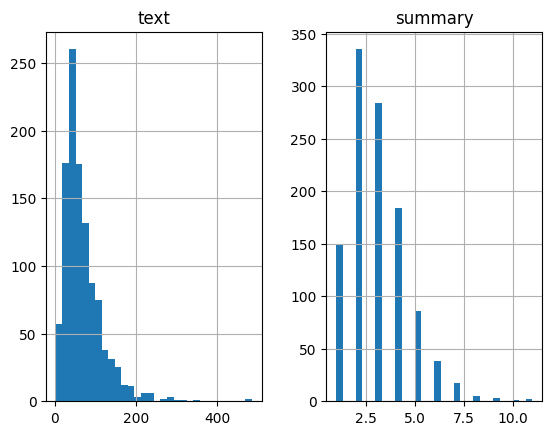

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split()))

for i in df['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in df['summary']:
    if(len(i.split()) <= 8):
        cnt=cnt+1
print(cnt/len(df['summary']))

0.9945652173913043


In [ ]:
cnt=0
for i in df['text']:
    if(len(i.split()) <= 100):
        cnt=cnt+1
print(cnt/len(df['text']))

0.8097826086956522


In [ ]:
max_text_len=100
max_summary_len=8

Sortir panjang text dan summary agar di bawah atau sama dengan max_text_len dan max_summary_len

In [ ]:
cleaned_text =np.array(df['text'])
cleaned_summary=np.array(df['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df_new=pd.DataFrame({'text':short_text,'summary':short_summary}) # new dataframe to use

In [ ]:
# add the START and END special tokens at the beginning and end of the summary. Here, We have chosen sostok and eostok as START and END tokens
df_new['summary'] = df_new['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_new.head()

,text,summary
0,leko rupa resto penyet khas jawa timur mes empal penyet nasi goreng bakso empal penyet empuk bumbu asa sambal enak mantap sayang kasih lalap dikit nasi goreng bakso so so aja nasi goreng minyak ma...,sostok penyet jawa timur eostok
1,bukber temen2 sen yg ayam bakar penyet bumbu ayam nya asa bgt manis trus daging nya gak keras liat overcook ngga pait sambelnya suka gak pedes yg cetar poko bikin makan lahap deh suasana nya nyama...,sostok ayam bakarr eostok
2,menu pesan nasi goreng teri medan lumayan enak ga asin gurih pas minyak dikit ok servicenya ramah nyaman,sostok nasi goreng teri medan eostok
3,unjung outlet warung leko sedia aneka hidang penyet khas jawa timur mes menu andal iga penyet a sate jamur tingkat level pedas iga sapi empuk gurih sambal cobek ga pedas sesuai request sate jamur ...,sostok juicy eostok
4,warung leko mah ud gausa diraguin ya rata2 masakan enak sen iga empal penyet enak pol daging empuk sambelnya maknyus request tingkat pedas jamur goreng tepung jgn lupa sen endul layan cepat ramah ...,sostok enak puas bgt pokok eostok


Split data dan menyeiapkan Tokenizer

In [ ]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df_new['text']), np.array(df_new['summary']),
                                       test_size=0.1, random_state=0, shuffle=True)

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

Rarewords

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 74.02855593710464
Total Coverage of rare words: 13.79124248742794


In [ ]:
print(cnt),print(tot_cnt)

4096
5533


(None, None)

In [ ]:
print(freq),print(tot_freq)

5622
40765


(None, None)

Text Tokenizer

In [ ]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
print(x_voc)

1438


In [ ]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

Summary Tokenizer

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 90.42675893886967
Total Coverage of rare words: 31.352880658436217


In [ ]:
print(cnt),print(tot_cnt)
print(freq),print(tot_freq)

784
867
1219
3888


(None, None)

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print(y_voc)

84


In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

#Model

Abstractive Text Summarization: the model simply selects and rearranges phrases or sentences that already exist in the original text

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention

In [ ]:
latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model without attention layer
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             143800    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 100, 300),           481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Using EarlyStopping, model will stop training once the validatioin loss increases.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=20,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/20
5/5 [==============================] - 31s 2s/step - loss: 3.5128 - accuracy: 0.4776 - val_loss: 1.6255 - val_accuracy: 0.6320
Epoch 2/20
5/5 [==============================] - 7s 1s/step - loss: 1.9024 - accuracy: 0.5552 - val_loss: 1.4330 - val_accuracy: 0.6991
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 1.5244 - accuracy: 0.6701 - val_loss: 1.3793 - val_accuracy: 0.6991
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 1.4961 - accuracy: 0.6675 - val_loss: 1.3652 - val_accuracy: 0.7316
Epoch 5/20
5/5 [==============================] - 9s 2s/step - loss: 1.4971 - accuracy: 0.6728 - val_loss: 1.3767 - val_accuracy: 0.6558
Epoch 6/20
5/5 [==============================] - 6s 1s/step - loss: 1.4606 - accuracy: 0.6709 - val_loss: 1.3462 - val_accuracy: 0.7359
Epoch 7/20
5/5 [==============================] - 9s 2s/step - loss: 1.4451 - accuracy: 0.6895 - val_loss: 1.3389 - val_accuracy: 0.6688
Epoch 8/20
5/5 [=======================

In [ ]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

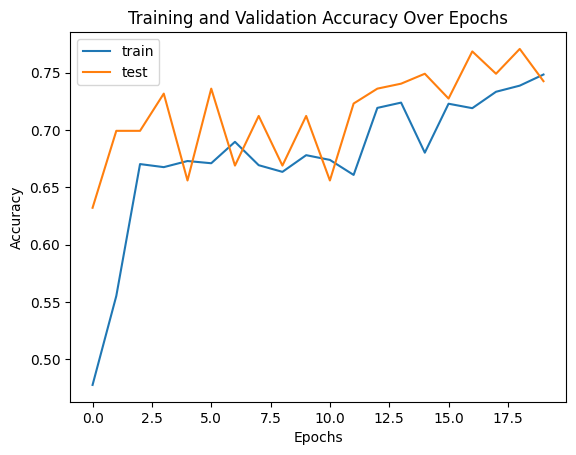

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.title('Training and Validation Accuracy Over Epochs')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.show()

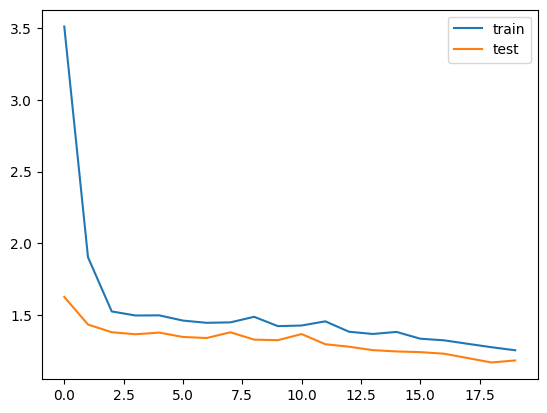

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Inference

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup without attention
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model without attention
decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0, 10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: pe ama kali nyoba claypot popo overall makan enak enak nyaman karna duduk ac persis haha sen menu siomay ikan makan aja nunggu claypot dateng enak banget lumayan gede sih bentuk anget anget pake saos bikin nagih claypot sapi cah bawang putih suka banget kuah udah dingin tp anget dikit daging empuk asa bawang putih suka banget temenku sen claypot siram telur matang sapi coba aja sih pake chili oil lumayan pedes aja asa kaldu haha next time kalo makan sabar chili btw temenku porsi nasi hehe next kesini nasi aja 
Original summary: banget 
1/1 [==============================] - 1s 1s/step


ValueError: ignored